In [9]:
!wget -O Audio_Song_Actors_01-24.zip "https://zenodo.org/records/1188976/files/Audio_Song_Actors_01-24.zip?download=1"
!unzip Audio_Song_Actors_01-24.zip -d Audio_Song_Actors
!wget -O Audio_Speech_Actors_01-24.zip "https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip?download=1"
!unzip Audio_Speech_Actors_01-24.zip -d Audio_Speech_Actors

--2025-06-14 03:50:50--  https://zenodo.org/records/1188976/files/Audio_Song_Actors_01-24.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225505317 (215M) [application/octet-stream]
Saving to: ‘Audio_Song_Actors_01-24.zip’

Audio_Song_Actors_0 100%[===================>] 215.06M  21.6MB/s    in 44s     

2025-06-14 03:51:35 (4.87 MB/s) - ‘Audio_Song_Actors_01-24.zip’ saved [225505317/225505317]

Archive:  Audio_Song_Actors_01-24.zip
   creating: Audio_Song_Actors/Actor_01/
  inflating: Audio_Song_Actors/Actor_01/03-02-01-01-01-01-01.wav  
  inflating: Audio_Song_Actors/Actor_01/03-02-01-01-01-02-01.wav  
  inflating: Audio_Song_Actors/Actor_01/03-02-01-01-02-01-01.wav  
  inflating: Audio_Song_Actors/Actor_01/03-02-01-01-02-02-01.wav  
  inflating: Audio_Song_Actors/Actor_01/03-02-02-01-01-01-01.wav  
  infla

In [10]:
!pip install librosa lazypredict scikit-learn pandas tqdm -q

In [11]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lazypredict.Supervised import LazyClassifier

In [12]:
emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

def get_emotion_from_filename(filename):
    try:
        code = filename.split("-")[2]
        return emotion_map.get(code)
    except:
        return None

In [13]:
def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [14]:
!pip install resampy -q

In [15]:
data = []
labels = []
import resampy
# Change these to your actual folders
main_folders = ["/content/Audio_Speech_Actors", "/content/Audio_Song_Actors"]

for folder in main_folders:
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for file in tqdm(os.listdir(subfolder_path)):
            if file.endswith(".wav"):
                emotion = get_emotion_from_filename(file)
                if emotion is None:
                    continue
                features = extract_features(os.path.join(subfolder_path, file))
                if features is not None:
                    data.append(features)
                    labels.append(emotion)

df = pd.DataFrame(data)
df['emotion'] = labels

100%|██████████| 44/44 [00:05<00:00,  7.44it/s]
0it [00:00, ?it/s]
100%|██████████| 44/44 [00:04<00:00,  8.91it/s]


In [16]:
X = df.drop('emotion', axis=1)
y = df['emotion']

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 2406, number of used features: 40
[LightGBM] [Info] Start training from score -2.088627
[LightGBM] [Info] Start training from score -2.068693
[LightGBM] [Info] Start training from score -2.091989
[LightGBM] [Info] Start training from score -2.078611
[LightGBM] [Info] Start training from score -2.052380
[LightGBM] [Info] Start training from score -2.058873
[LightGBM] [Info] Start training from score -2.108967
[LightGBM] [Info] Start training from score -2.088627
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LGBMClassifier                     0.83               0.83    None      0.83   
ExtraTreesClassifier               0.81

In [17]:
from sklearn.ensemble import ExtraTreesClassifier

best_model = ExtraTreesClassifier(class_weight='balanced', n_estimators=1000, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

       angry       0.89      0.79      0.84        78
        calm       0.77      0.90      0.83        72
     disgust       0.75      0.87      0.81        79
     fearful       0.71      0.77      0.74        75
       happy       0.87      0.58      0.70        67
     neutral       0.96      0.97      0.96        69
         sad       0.88      0.63      0.74        84
   surprised       0.79      1.00      0.88        78

    accuracy                           0.82       602
   macro avg       0.83      0.82      0.81       602
weighted avg       0.83      0.82      0.81       602



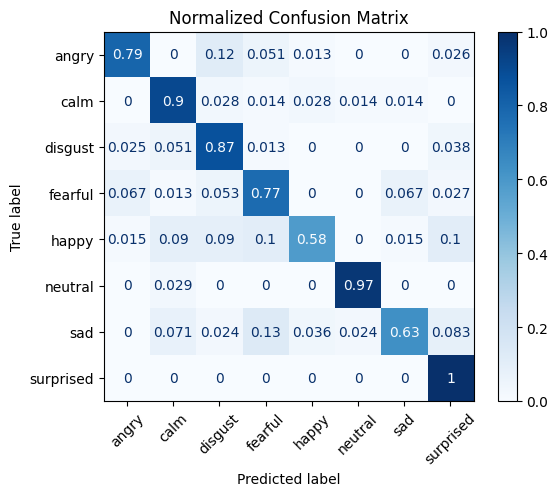

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
# Decode labels if using label encoder
y_test_decoded = encoder.inverse_transform(y_test)
y_pred_decoded = encoder.inverse_transform(y_pred)
# Confusion Matrix (Raw)
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=encoder.classes_)

# Confusion Matrix (Normalized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Normalized Confusion Matrix")
plt.grid(False)
plt.show()

In [19]:
df.shape

(2452, 41)

In [20]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 10.4 MB/s eta 0:00:00


[I 2025-06-14 04:01:38,968] A new study created in memory with name: etc_min_class_recall


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-06-14 04:02:10,067] Trial 0 finished with value: 0.5690582010582012 and parameters: {'n_estimators': 900, 'max_depth': 20, 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5690582010582012.
[I 2025-06-14 04:02:39,192] Trial 1 finished with value: 0.5546666666666668 and parameters: {'n_estimators': 1000, 'max_depth': 15, 'min_samples_split': 10, 'max_features': 0.8}. Best is trial 0 with value: 0.5690582010582012.
[I 2025-06-14 04:02:51,826] Trial 2 finished with value: 0.5186031746031746 and parameters: {'n_estimators': 900, 'max_depth': 50, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5690582010582012.
[I 2025-06-14 04:03:02,778] Trial 3 finished with value: 0.6 and parameters: {'n_estimators': 400, 'max_depth': 45, 'min_samples_split': 5, 'max_features': 0.5}. Best is trial 3 with value: 0.6.
[I 2025-06-14 04:03:13,613] Trial 4 finished with value: 0.592973544973545 and parameters: {'n_estimators': 600, 'max_dept

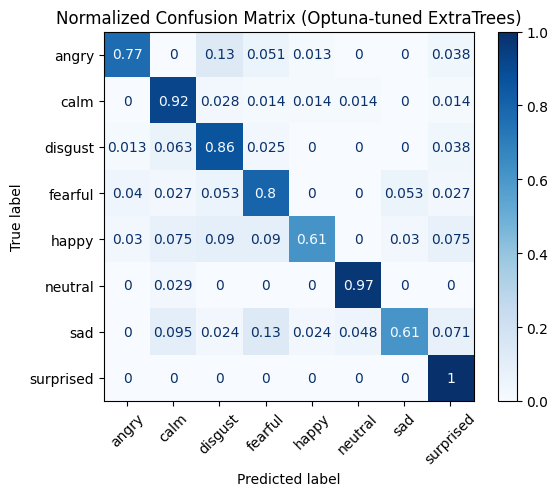

In [21]:
import optuna
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedKFold

def objective(trial):
    # 1. Suggest hyperparameters
    n_estimators     = trial.suggest_int('n_estimators', 200, 1000, step=100)
    max_depth        = trial.suggest_int('max_depth', 5, 50, step=5)
    min_samples_split= trial.suggest_int('min_samples_split', 2, 10)
    max_features     = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 0.8])

    # 2. Initialize classifier with class weights
    clf = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        max_features=max_features,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    # 3. Stratified CV to get robust recall estimates
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    min_recalls = []

    for train_idx, valid_idx in skf.split(X_res, y_res):
        X_tr, X_val = X_res[train_idx], X_res[valid_idx]
        y_tr, y_val = y_res[train_idx], y_res[valid_idx]

        clf.fit(X_tr, y_tr)
        preds = clf.predict(X_val)

        # per‑class recall
        recalls = recall_score(y_val, preds, average=None)
        min_recalls.append(recalls.min())

    # 4. We return the average of the minimum recall across folds
    return np.mean(min_recalls)

# 5. Run the study
study = optuna.create_study(
    direction='maximize',
    study_name='etc_min_class_recall'
)
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("Best trial:")
print(study.best_trial.params)
print("Best value (min class recall):", study.best_value)

# 6. Retrain on full training set with best params
best_params = study.best_trial.params
best_model = ExtraTreesClassifier(
    **best_params,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
best_model.fit(X_train, y_train)

# 7. Final evaluation on your held‑out test set
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)
y_test_decoded = encoder.inverse_transform(y_test)
y_pred_decoded = encoder.inverse_transform(y_pred)

print("Classification Report:")
print(classification_report(y_test_decoded, y_pred_decoded, target_names=encoder.classes_))

# Normalized confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=encoder.classes_)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, None]

disp = ConfusionMatrixDisplay(cm_norm, display_labels=encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Normalized Confusion Matrix (Optuna‑tuned ExtraTrees)")
plt.grid(False)
plt.show()


In [22]:
df.shape

(2452, 41)

100%|██████████| 44/44 [00:06<00:00,  6.31it/s]
0it [00:00, ?it/s]
100%|██████████| 44/44 [00:06<00:00,  6.32it/s]


              precision    recall  f1-score   support

       angry       0.97      0.95      0.96       150
        calm       0.90      0.99      0.94       150
     disgust       0.89      1.00      0.94       151
     fearful       0.88      0.95      0.92       151
       happy       0.90      0.74      0.81       151
     neutral       0.97      0.98      0.97       150
         sad       0.92      0.75      0.83       151
   surprised       0.93      0.99      0.96       150

    accuracy                           0.92      1204
   macro avg       0.92      0.92      0.92      1204
weighted avg       0.92      0.92      0.92      1204



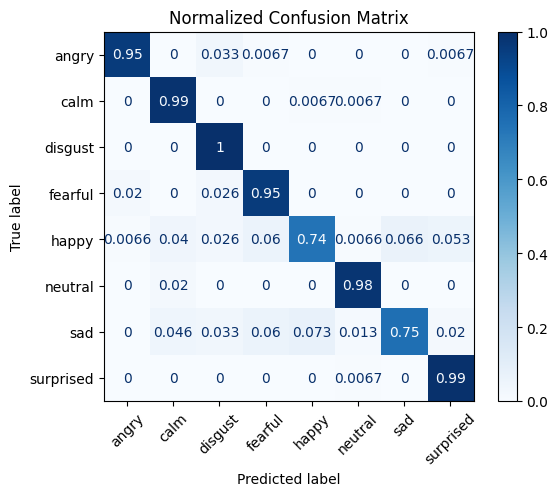

In [23]:
import os
import numpy as np
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
import pandas as pd

# 1) Emotion map and augment-only list
emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}
augment_classes = {"happy", "sad"}

# 2) Augmentation functions
# def pitch_shift(y, sr, n_steps=2):
#     return librosa.effects.pitch_shift(y, sr, n_steps=n_steps)

# def time_stretch(y, rate=1.1):
#     return librosa.effects.time_stretch(y, rate)

def add_noise(y, noise_level=0.005):
    noise = np.random.randn(len(y))
    return y + noise_level * noise

# 3) Feature extraction helpers
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None, res_type='kaiser_fast')
    return extract_features_from_signal(y, sr)

def extract_features_from_signal(y, sr):
    mfcc  = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc_mean, mfcc_std = np.mean(mfcc, axis=1), np.std(mfcc, axis=1)
    delta1 = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    spec_con = librosa.feature.spectral_contrast(y=y, sr=sr)
    chroma  = librosa.feature.chroma_stft(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(chroma=chroma, sr=sr)
    return np.hstack([
        mfcc_mean, mfcc_std,
        np.mean(delta1, axis=1), np.mean(delta2, axis=1),
        np.mean(spec_con, axis=1),
        np.mean(tonnetz, axis=1)
    ])

# 4) Build dataset
data, labels = [], []
main_folders = ["/content/Audio_Speech_Actors", "/content/Audio_Song_Actors"]

for folder in main_folders:
    for sub in os.listdir(folder):
        sub_path = os.path.join(folder, sub)
        if not os.path.isdir(sub_path): continue
        for fname in tqdm(os.listdir(sub_path)):
            if not fname.endswith(".wav"): continue
            emo_code = fname.split("-")[2]
            emo = emotion_map.get(emo_code)
            if emo is None: continue

            full_path = os.path.join(sub_path, fname)

            # Original
            feat = extract_features(full_path)
            data.append(feat)
            labels.append(emo)

            # Augment only for selected emotions
            if emo in augment_classes:
                y, sr = librosa.load(full_path, sr=None, res_type='kaiser_fast')
                # y_ps = pitch_shift(y, sr, n_steps=2)
                # data.append(extract_features_from_signal(y_ps, sr))
                # labels.append(emo)

                # y_ts = time_stretch(y, rate=0.9)
                # data.append(extract_features_from_signal(y_ts, sr))
                # labels.append(emo)

                y_no = add_noise(y, noise_level=0.003)
                data.append(extract_features_from_signal(y_no, sr))
                labels.append(emo)

# 5) Prepare dataset
df = pd.DataFrame(data)
df['emotion'] = labels

X = df.drop('emotion', axis=1).values
encoder = LabelEncoder()
y = encoder.fit_transform(df['emotion'])

# 6) Scale + SMOTE + Split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# 7) Train + Evaluate
from sklearn.ensemble import ExtraTreesClassifier

best_model = ExtraTreesClassifier(class_weight='balanced', n_estimators=600, max_depth=25, min_samples_split=3, max_features= 0.8,random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
# Decode labels if using label encoder
y_test_decoded = encoder.inverse_transform(y_test)
y_pred_decoded = encoder.inverse_transform(y_pred)
# Confusion Matrix (Raw)
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=encoder.classes_)

# Confusion Matrix (Normalized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Normalized Confusion Matrix")
plt.grid(False)
plt.show()


In [24]:
# After training
import joblib
joblib.dump(best_model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoder, "encoder.pkl")

['encoder.pkl']